In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpy as np
from temgym_core.components import Detector
from temgym_core.utils import wavelength2energy
from temgym_core.gaussian import GaussianRayBeta, TaylorExpofAction
from temgym_core.gaussian_taylor import (
    FreeSpaceParaxial, 
    SigmoidAperture,
    run_to_end,
)
from temgym_core.evaluate import (
    evaluate_gaussians_jax_scan,
    evaluate_gaussians_for
)
from temgym_core.utils import fibonacci_spiral

jax.config.update("jax_enable_x64", True)

In [2]:
W = 20.0  # Width of the simulation cell in nm

Nx = Ny = 128
dx = W/Nx
dy = W/Ny
grid = Detector(z=0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = grid.coords
X, Y = coords[:,0].reshape(grid.shape), coords[:,1].reshape(grid.shape)
x, y = X[0,:], Y[:,0]
extent = (x[0], x[-1], y[0], y[-1])

wavelength = 0.025  # Wavelength in nm (200 keV electrons)
k = 2 * jnp.pi / wavelength  # Wavenumber in nm^-1

# Target amplitude outside the aperture; amplitude = exp(imag(k*S)), so need imag(S)<0
A_target = 1e-2
L_outside = k * jnp.log(-A_target)  # negative length so that imag(S) = L_outside < 0 and exp(k*L_outside)=A_target
aperture = SigmoidAperture(radius=W/4, sharpness=1000, z=0.0, L_outside=L_outside)
components = [aperture, grid]

# in your experiment setup (once), convert target amplitude to length:
# A_out in (0,1], k scalar, wavelength known here


TypeError: SigmoidAperture.__init__() got an unexpected keyword argument 'L_outside'

In [7]:
angstroms_to_metres = 1e-10
voltage = wavelength2energy(wavelength * angstroms_to_metres) # wavelength in meters as this function expects SI units
k0 = 2 * jnp.pi / wavelength
num_rays = 1

key1, key2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)
num_rays_sqrt = int(jnp.ceil(jnp.sqrt(num_rays)))

# rx, ry = fibonacci_spiral(num_rays, radius=W/4)
rx, ry = 0.0, 0.0
w0 = 5 # Beam waist
q = -1j * (2.0 / (k0 * w0**2))
Q_inv = jnp.array([[q, 0.0], [0.0, q]])
Q_inv = jnp.tile(Q_inv, (num_rays, 1, 1))

aperture_area = np.pi * (W / 4)**2
scale_factor = aperture_area / (w0 ** 2 * num_rays * np.pi)
C0 = jnp.ones(num_rays) * (1.0 * scale_factor + 0.0j)
eta = jnp.full((num_rays, 2), 0.0+0.0j)

voltage = jnp.full((num_rays,), voltage)

S = TaylorExpofAction(
    const=jnp.zeros(num_rays, dtype=jnp.complex128),
    lin=jnp.zeros((num_rays, 2), dtype=jnp.complex128),
    quad=Q_inv,
)
ray_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=jnp.zeros(num_rays), 
                         dy=jnp.zeros(num_rays), 
                         z=jnp.zeros(num_rays), 
                         pathlength=jnp.zeros(num_rays),
                         C=C0,
                         S=S,
                         voltage=voltage)

ray_out = run_to_end(ray_in, [grid])

In [4]:
E_in = evaluate_gaussians_for(ray_out, grid)

In [5]:
# ray_out = run_to_end(ray_in, components)
# # E_prop = eval_gaussians_gpu_kernel_wrapper(ray_out, grid)

# E_prop = evaluate_gaussians_jax_scan(ray_out, grid)

/tmp/ipykernel_89633/161246940.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  plt.plot(rx, ry, 'rx', color='blue', markersize=8, label='Ray Origin')


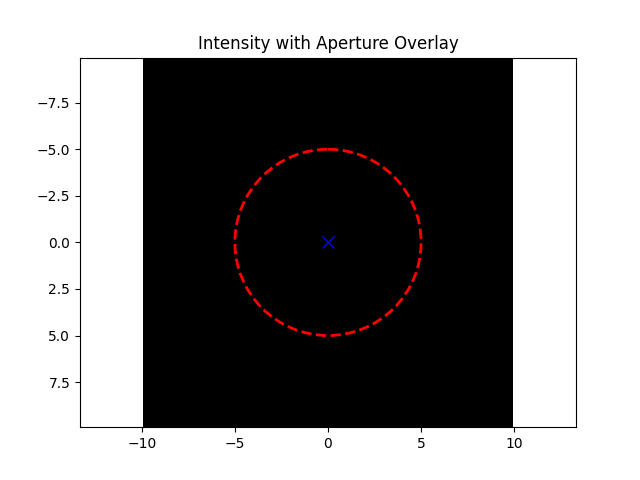

In [6]:
plt.figure()
plt.title('Intensity with Aperture Overlay')
plt.axis('equal')
circle = plt.Circle((0, 0), aperture.radius, color='red', fill=False, linestyle='--', linewidth=2)
plt.gca().add_artist(circle)
plt.plot(rx, ry, 'rx', color='blue', markersize=8, label='Ray Origin')
plt.imshow(np.abs(E_in), cmap='gray', extent=extent)

# plt.figure()
# plt.title('Intensity after Propagation')    
# plt.axis('equal')
# plt.imshow(np.abs(E_prop), cmap='gray', extent=extent)
